### Imports

In [1]:
import pandas as pd
import numpy as np
import subprocess
import os
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

### load raw data

In [7]:
# load data
braker = pd.read_csv('./braker.gff3_red', sep='\t')

### process into chunks and send off to slurm

In [8]:
#split into chunks and write them
chunk_n = 200
braker_split = np.array_split(braker, chunk_n)

In [9]:
def create_and_submit_sbatch(batch, chunk):
    name="CpG_batch{batch}.job".format(batch=batch)
    sbatch = [ "#!/bin/bash -l",
                    "#SBATCH -A naiss2023-22-450",
                    "#SBATCH -t 2:0:0 ",
                    "#SBATCH -p core -n 1",
                    "#SBATCH -J {name}".format(name=name),
                    "#SBATCH -o {name}_%j.out".format(name=name),
                    "#SBATCH -e {name}_%j.error".format(name=name),
                    "#SBATCH --get-user-env",
                    "##command underneath this##",
                    "conda activate base",
                    "python get_Mbel_cpg_chunk.py --input {chunk}".format(chunk=chunk)]
    with open(name, 'wt') as handle:
        handle.write("\n".join(sbatch))
    subprocess.call(["chmod", "766", name])
    subprocess.call(["sbatch", name])

In [6]:
#data = pd.read_csv("Mbel_per_base_content_wind_1000b_repeatmask_xcount.txt", sep='\t')

In [11]:
#bin_pos =[]
#start =0
#stop = 1e3
#scf_d = dict()
#for i,k in data.iterrows():
#    if k["contig"] not in scf_d:
#        start =0
#        stop = 1e3
#        scf_d[k["contig"]]=True
#    bin_pos.append([start, stop])
#    start = start+1e3
#    stop = stop+1e3

#bpdf = pd.DataFrame(bin_pos)   
#data["bin_start"] =bpdf[0]
#data["bin_stop"] =bpdf[1]

In [17]:
#data.to_csv("20230708_Mbel_CpG_1kbwindow_with_start_stop_pos.csv")

In [5]:
row = braker.iloc[4,]

NameError: name 'data' is not defined

In [34]:
ss_data = data.loc[data.contig==row.Scaffold].loc[(data.bin_start)<row.End_pos].loc[(data.bin_stop)>row.Start_pos]


In [50]:
len(braker_split)

200

In [10]:
cfiles = []
for i, k in enumerate(braker_split):
    #print(i)
    chunkname = "braker_chunks2/braker_chunk_{chunk_i}.gff3_chunk".format(chunk_i=i)
    #k.to_csv(chunkname)
    cname = "braker_chunk_{chunk_i}.gff3_chunk".format(chunk_i=i)
    #cfiles.append(cname)
    #print(cname.rsplit(".")[0]+'.cpg')
    #print(cname)
    #if cname.rsplit(".")[0]+'.cpg' not in cpg_chunks:
        #print(cname)
       # print(cname.rsplit(".")[0]+'.cpg')
    #cfiles.append(cname.rsplit(".")[0]+'.cpg')
    create_and_submit_sbatch(batch=i, chunk=chunkname)

Submitted batch job 39523572
Submitted batch job 39523573
Submitted batch job 39523574
Submitted batch job 39523575
Submitted batch job 39523576
Submitted batch job 39523577
Submitted batch job 39523578
Submitted batch job 39523579
Submitted batch job 39523580
Submitted batch job 39523581
Submitted batch job 39523582
Submitted batch job 39523583
Submitted batch job 39523584
Submitted batch job 39523585
Submitted batch job 39523586
Submitted batch job 39523587
Submitted batch job 39523588
Submitted batch job 39523589
Submitted batch job 39523590
Submitted batch job 39523591
Submitted batch job 39523592
Submitted batch job 39523593
Submitted batch job 39523594
Submitted batch job 39523595
Submitted batch job 39523596
Submitted batch job 39523597
Submitted batch job 39523598
Submitted batch job 39523599
Submitted batch job 39523600
Submitted batch job 39523601
Submitted batch job 39523602
Submitted batch job 39523603
Submitted batch job 39523604
Submitted batch job 39523605
Submitted batc

In [13]:
len(cfiles)

200

In [15]:
#cfiles

In [63]:
len(braker_split)

200

In [45]:
cpg_chunks =  [ i for i in os.listdir("./braker_chunks2") if i.endswith(".cpg")]

In [51]:
len(cpg_chunks) # all chunks are there

181

In [152]:
rho_chunks_df = pd.concat([pd.read_csv(os.path.join("./braker_chunks2",i), header=None) for i in rho_chunks])

In [153]:
rho_chunks_df = rho_chunks_df.sort_values([1,3,4])

In [154]:
rho_chunks_df.columns = ["old_index"]+list(braker.columns)+['weighted_mean_rho']

### how many genes do not have an associated rho-value?

In [141]:
Counter(rho_chunks_df.weighted_mean_rho).most_common(5)

[('no_overlap_bin', 37204),
 ('1.31625', 1458),
 ('0.00682', 1154),
 ('0.02511', 1064),
 ('28.8939', 865)]

In [145]:
rho_chunks_df.shape

(827909, 7)

In [143]:
(37204/823770)*100

4.51630916396567

#### roughly 4.5%

### plotting

In [157]:
rho_chunks_df.weighted_mean_rho

270     0.66661
271     0.66661
272     0.66661
273     0.66661
274     0.66661
         ...   
2833    0.08865
2834    0.08865
2835    0.08865
2836    0.08865
2837    0.08865
Name: weighted_mean_rho, Length: 827909, dtype: object

In [158]:
# drop missing values
rho_chunks_df=rho_chunks_df.replace('no_overlap_bin', np.nan)

In [160]:
rho_chunks_df.weighted_mean_rho = rho_chunks_df.weighted_mean_rho.astype(float)

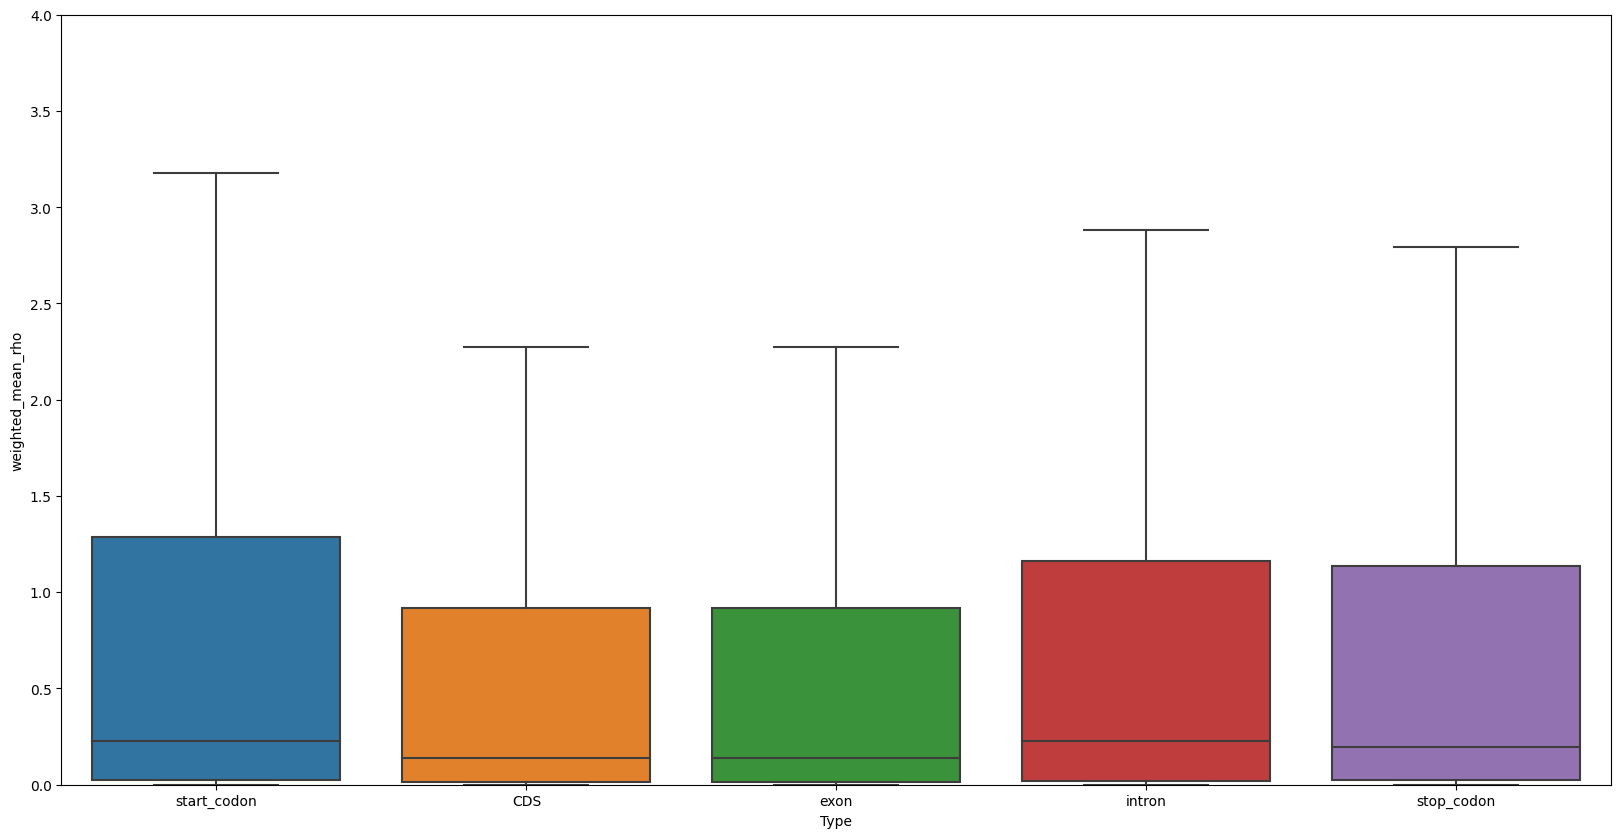

In [175]:
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(20,10))
sns.boxplot(x=rho_chunks_df["Type"], y=rho_chunks_df["weighted_mean_rho"],fliersize=0, ax=ax )
plt.ylim(0,4)
plt.show()                       

In [68]:
 "braker_chunk_13.cpg" in cpg_chunks

False

In [177]:
gb_rho = rho_chunks_df.groupby("Type")

In [179]:
gb_rho.weighted_mean_rho.mean()

Type
CDS            3.508157
exon           3.508157
intron         3.498127
start_codon    3.836048
stop_codon     3.761558
Name: weighted_mean_rho, dtype: float64

In [181]:
gb_rho.weighted_mean_rho.std()

Type
CDS            10.836931
exon           10.836931
intron         10.512917
start_codon    11.772698
stop_codon     12.016225
Name: weighted_mean_rho, dtype: float64

In [183]:
gb_rho.weighted_mean_rho.median()

Type
CDS            0.13708
exon           0.13708
intron         0.22722
start_codon    0.22746
stop_codon     0.19728
Name: weighted_mean_rho, dtype: float64